In [10]:
# --- Célula 1: Imports e Configurações ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import shap
import xgboost

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

cols_dict = {
    'track_id': 'Track ID', 'artists': 'Artists', 'album_name': 'Album Name',
    'track_name': 'Track Name', 'popularity': 'Popularity', 'duration_ms': 'Duration (ms)',
    'explicit': 'Explicit', 'danceability': 'Danceability', 'energy': 'Energy',
    'key': 'Key', 'loudness': 'Loudness', 'mode': 'Mode', 'speechiness': 'Speechiness',
    'acousticness': 'Acousticness', 'instrumentalness': 'Instrumentalness',
    'liveness': 'Liveness', 'valence': 'Valence', 'tempo': 'Tempo',
    'time_signature': 'Time Signature', 'track_genre': 'Track Genre'
}

In [11]:
# --- Célula 2: Carregamento dos Dados ---
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
df = pd.read_csv(path + '/dataset.csv', index_col=0)
# Remova colunas duplicadas
df = df.loc[:, ~df.columns.duplicated()]
if 'track_genre' not in df.columns:
    df['track_genre'] = 'unknown'

num_features = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]

# Remova qualquer coluna extra
df = df[num_features + ['track_genre']].copy()


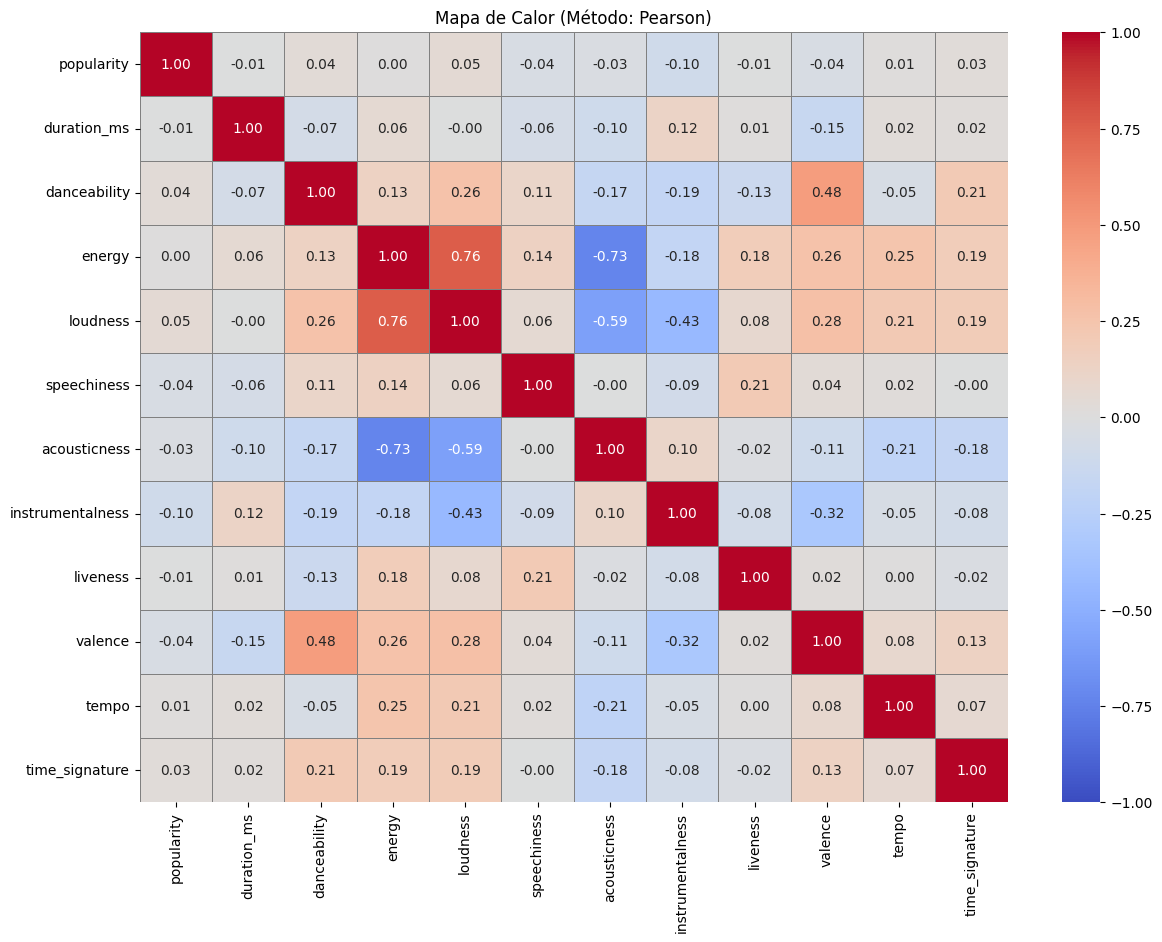

energy    loudness        0.761690
          acousticness   -0.733906
loudness  acousticness   -0.589803
dtype: float64

In [12]:
# --- Célula 8: Correlação ---
corr_method = "pearson"
corr_matrix = df[num_features].corr(method=corr_method)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
plt.title(f"Mapa de Calor (Método: {corr_method.capitalize()})")
plt.show()

# Pares com maior correlação
mask_table = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_unstacked = corr_matrix.where(mask_table).stack()
strong_pairs = corr_unstacked[abs(corr_unstacked) > 0.5].sort_values(key=abs, ascending=False)
display(strong_pairs)

Detectados 5695 outliers.


,track_genre,danceability,energy,loudness,acousticness,valence
17,acoustic,0.7950,0.0841,-18.090,0.742,0.6090
116,acoustic,0.5650,0.0392,-28.276,0.835,0.6010
117,acoustic,0.6640,0.0755,-19.836,0.910,0.5750
270,acoustic,0.6180,0.0830,-23.665,0.745,0.5970
284,acoustic,0.7340,0.0423,-24.831,0.916,0.1400
...,...,...,...,...,...,...
113977,world-music,0.0672,0.0903,-23.496,0.970,0.0361
113979,world-music,0.4170,0.9670,-27.146,0.924,0.0147
113986,world-music,0.1980,0.2570,-17.361,0.968,0.0381
113995,world-music,0.1720,0.2350,-16.393,0.640,0.0339


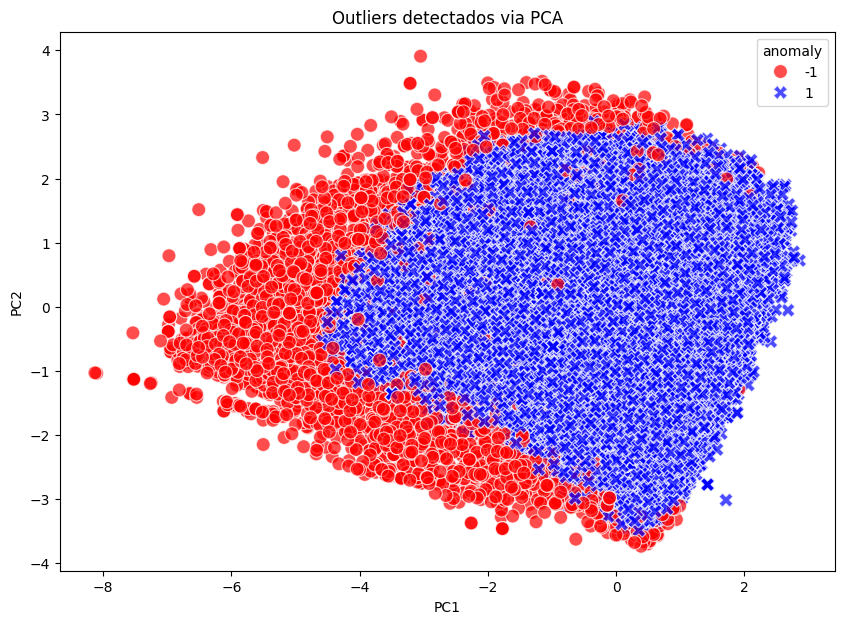

In [13]:
# --- Célula 9: Detecção de Outliers com Isolation Forest ---
features_for_outliers = ['danceability', 'energy', 'loudness', 'acousticness', 'valence']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_for_outliers])
iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(X_scaled)
outliers = df[df['anomaly'] == -1]
print(f"Detectados {len(outliers)} outliers.")
display(outliers[['track_genre'] + features_for_outliers])

# Visualização PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df.index)
df_pca['anomaly'] = df['anomaly']
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='anomaly', palette={1: 'blue', -1: 'red'}, style='anomaly', s=100, alpha=0.7)
plt.title("Outliers detectados via PCA")
plt.show()

#remoção
df_no_outliers = df[df['anomaly'] != -1].copy()

# Agrupar gêneros pouco frequentes
min_count = 100  # ajuste conforme o tamanho do seu dataset
top_genres = df_no_outliers['track_genre'].value_counts()[lambda x: x >= min_count].index
df_no_outliers['track_genre_grouped'] = df_no_outliers['track_genre'].where(df_no_outliers['track_genre'].isin(top_genres), 'outros')


In [14]:
# --- Célula 10: Pré-processamento dos Dados ---
df_processed = df_no_outliers.copy()
# Imputação pela mediana
df_processed[num_features] = df_processed[num_features].fillna(df_processed[num_features].median())
# Padronização
scaler = StandardScaler()
df_processed[num_features] = scaler.fit_transform(df_processed[num_features])

display(df_processed.head())

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,anomaly,track_genre_grouped
0,1.766553,0.021907,0.608957,-0.875945,0.217634,0.553016,-0.820430,-0.459803,0.761091,0.907196,-1.202979,0.211623,acoustic,1,acoustic
1,0.962068,-0.774264,-0.980838,-2.154337,-2.637652,-0.083566,1.995760,-0.459787,-0.599020,-0.874659,-1.559191,0.211623,acoustic,1,acoustic
2,1.051456,-0.172971,-0.869056,-1.317965,-0.595751,-0.280171,-0.258961,-0.459806,-0.514344,-1.459330,-1.598713,0.211623,acoustic,1,acoustic
3,1.677166,-0.260322,-1.937200,-2.615424,-2.986090,-0.465324,1.935760,-0.459555,-0.434960,-1.367850,2.001937,-2.433478,acoustic,1,acoustic
4,2.168795,-0.290575,0.248769,-0.953949,-0.581323,-0.309757,0.558928,-0.459806,-0.694810,-1.272394,-0.108792,0.211623,acoustic,1,acoustic


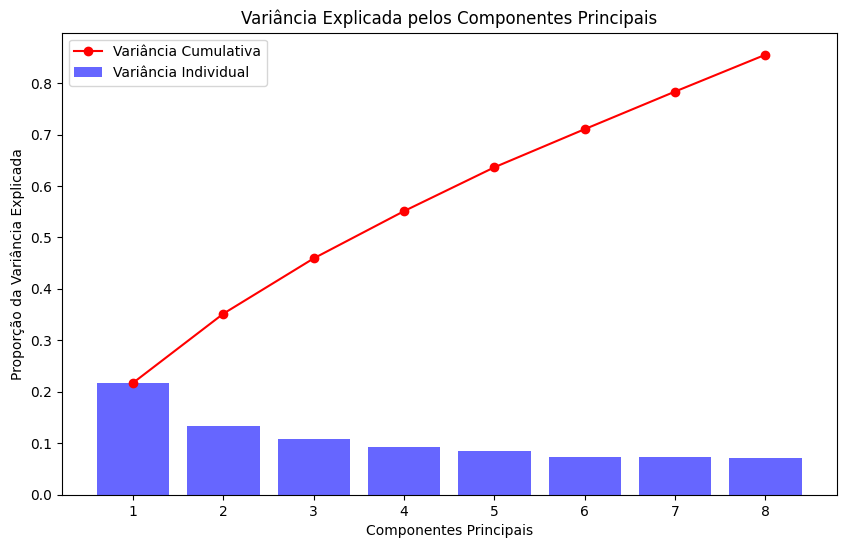

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8
0,0.353681,1.269035,0.212703,0.571542,1.883711,-0.199456,-0.667455,-0.064762
1,-4.122858,0.843727,0.244566,1.011264,1.018950,0.118852,0.635354,-0.723227
2,-1.610035,-0.380814,-0.268018,1.138156,1.334228,-0.724900,0.253461,-1.260689
3,-4.612118,-1.249699,1.367787,2.659527,-1.134707,1.492935,-1.202030,0.937881
4,-1.332805,0.123873,-0.510839,1.896623,1.260242,0.763036,-0.481671,-0.589435


In [15]:
# --- Célula 11: Redução de Dimensionalidade (PCA) (sem outliers) ---
n_components = 8
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(df_processed[num_features])
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.6, color='b', label='Variância Individual')
plt.plot(range(1, n_components + 1), cumulative_variance, 'r-o', label='Variância Cumulativa')
plt.xlabel('Componentes Principais')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Variância Explicada pelos Componentes Principais')
plt.legend(loc='best')
plt.xticks(range(1, n_components + 1))
plt.show()

df_pca = pd.DataFrame(X_pca, columns=[f'PC_{i+1}' for i in range(n_components)], index=df_processed.index)
display(df_pca.head())


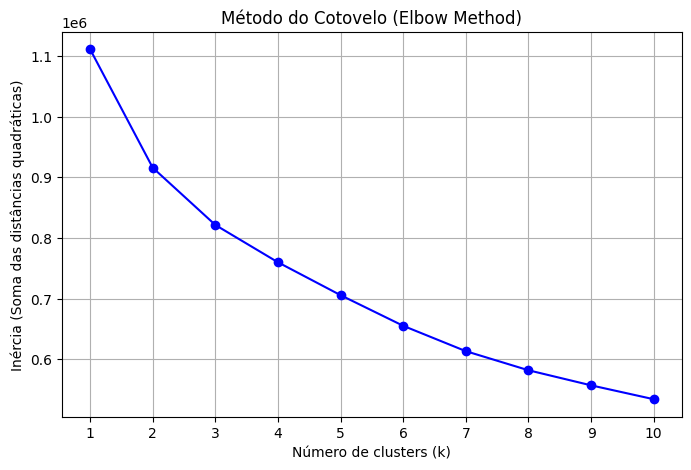

In [16]:
# --- Célula: Elbow Method para determinar o melhor número de clusters ---

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Use o DataFrame df_pca já criado após o PCA (sem a coluna 'cluster', se existir)
X_elbow = df_pca.drop(columns=['cluster'], errors='ignore')

inertias = []
k_range = range(1, 11)  # Testa de 1 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_elbow)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'o-', color='blue')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (Soma das distâncias quadráticas)')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

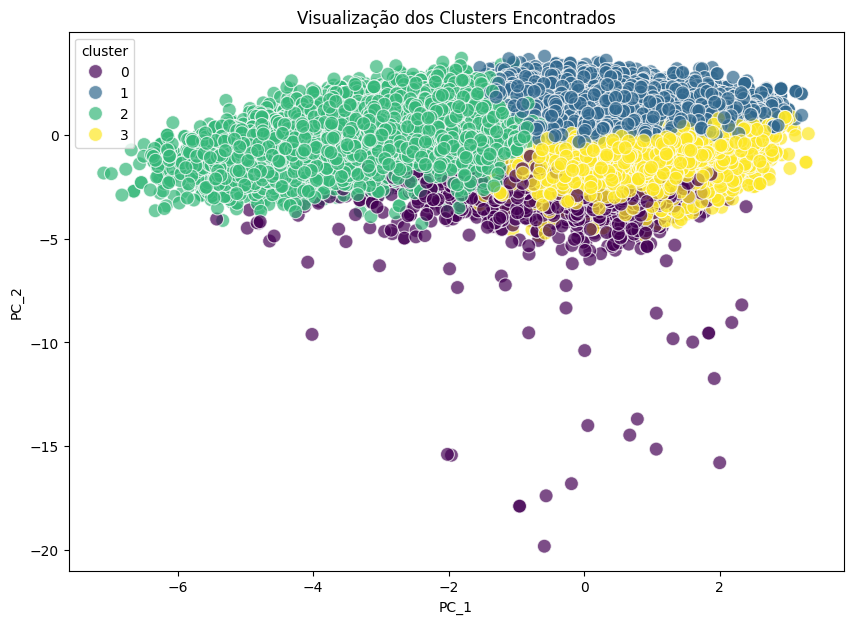

In [17]:
# --- Célula 12: Clusterização ---
k = 4
model = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = model.fit_predict(df_pca)
df_pca['cluster'] = labels

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC_1', y='PC_2', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title("Visualização dos Clusters Encontrados")
plt.show()

In [18]:
# --- Célula 13: Avaliação dos Clusters ---
silhouette_avg = silhouette_score(df_pca.iloc[:, :-1], labels)
davies_bouldin = davies_bouldin_score(df_pca.iloc[:, :-1], labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")

Silhouette Score: 0.156
Davies-Bouldin Score: 1.840


df_shap.columns: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']
num_features: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
df_shap[num_features].shape: (114000, 12)
X_train.columns: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
X_train.shape: (114000, 12)
model_rf.n_features_in_: 12
shap_values[0].shape: (12, 114)


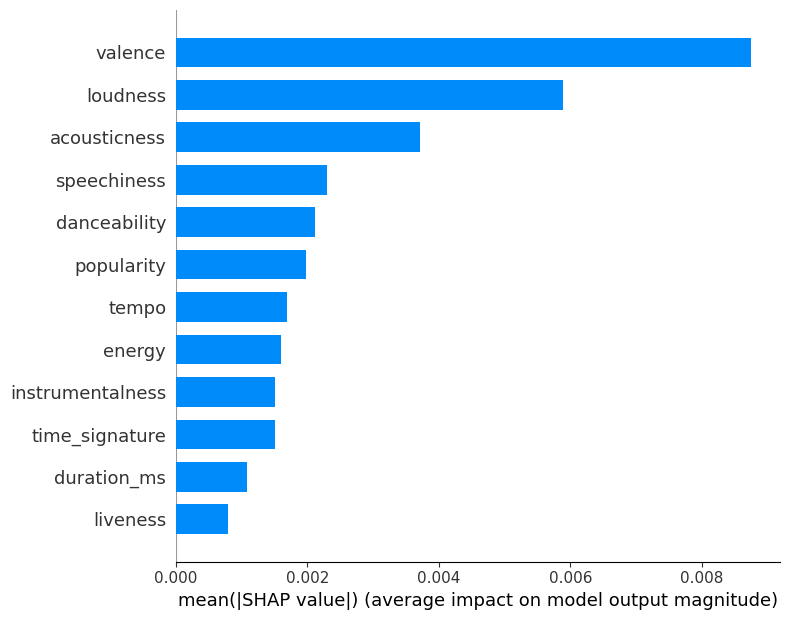

popularity          0.124258
duration_ms         0.096905
acousticness        0.094157
speechiness         0.091928
tempo               0.090507
danceability        0.090474
valence             0.087376
loudness            0.086091
energy              0.084353
liveness            0.077047
instrumentalness    0.067679
time_signature      0.009224
dtype: float64


In [19]:
# --- Célula 14: Interpretação SHAP ---
num_features = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]
df_shap = df[num_features + ['track_genre']].copy()

print("df_shap.columns:", list(df_shap.columns))
print("num_features:", num_features)
print("df_shap[num_features].shape:", df_shap[num_features].shape)

X_train = df_shap[num_features].copy()
y_train = df_shap['track_genre']

print("X_train.columns:", list(X_train.columns))
print("X_train.shape:", X_train.shape)

X_sample = X_train.sample(n=12, random_state=42) if len(X_train) > 12 else X_train

model_rf = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

print("model_rf.n_features_in_:", model_rf.n_features_in_)

explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_sample)
print("shap_values[0].shape:", shap_values[0].shape)
shap.summary_plot(shap_values[0][:, :X_sample.shape[1]], X_sample, plot_type="bar")

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(df_processed[num_features], df_no_outliers['track_genre'])
importances = pd.Series(rf.feature_importances_, index=num_features).sort_values(ascending=False)
print(importances)
# Use as top N features mais importantes
selected_features = importances.head(10).index.tolist()


In [20]:
# --- Célula: Classificação focada nos gêneros mais comuns e features mais importantes ---

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Agrupar gêneros pouco frequentes (top N)
top_n = 10  # ajuste conforme desejar
top_genres = df_no_outliers['track_genre'].value_counts().nlargest(top_n).index
df_no_outliers['track_genre_grouped'] = df_no_outliers['track_genre'].where(df_no_outliers['track_genre'].isin(top_genres), 'outros')

# 2. Usar apenas as features mais importantes
X = df_processed[selected_features]
y = df_no_outliers['track_genre_grouped']

# 3. Remover a classe 'outros'
mask = y != 'outros'
X = X[mask]
y = y[mask]

# Codificar os rótulos para inteiros
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y_encoded)

# 5. Limitar o tamanho do dataset balanceado (opcional)
max_samples = 5000  # ajuste conforme sua memória
if X_bal.shape[0] > max_samples:
    X_bal, y_bal = resample(X_bal, y_bal, n_samples=max_samples, random_state=42, stratify=y_bal)

# 6. Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)
# 7. Treinamento e avaliação
models = {
    "RandomForest": RandomForestClassifier(n_estimators=70, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBClassifier": XGBClassifier(n_estimators=70, use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    print("="*50)
    print(f"Modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Acurácia teste: {accuracy_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred), digits=2))
    # Matriz de confusão como DataFrame
    conf_df = pd.DataFrame(
        confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred)),
        index=le.classes_, columns=le.classes_
    )
    print("\nMatriz de Confusão:")
    print(conf_df)
    # Cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='accuracy')
    print(f"\nCV Accuracy média: {np.mean(cv_scores):.3f} | Desvio: {np.std(cv_scores):.3f}")
    print("="*50)

Modelo: RandomForest
Acurácia teste: 0.748

Classification Report:
               precision    recall  f1-score   support

        dance       0.79      0.87      0.83       100
drum-and-bass       0.91      0.87      0.89       100
       grunge       0.63      0.59      0.61       100
  heavy-metal       0.82      0.91      0.86       100
        j-pop       0.67      0.54      0.60       100
       j-rock       0.59      0.63      0.61       100
     mandopop       0.75      0.86      0.80       100
        metal       0.72      0.61      0.66       100
          pop       0.77      0.74      0.76       100
    reggaeton       0.80      0.86      0.83       100

     accuracy                           0.75      1000
    macro avg       0.75      0.75      0.74      1000
 weighted avg       0.75      0.75      0.74      1000


Matriz de Confusão:
               dance  drum-and-bass  grunge  heavy-metal  j-pop  j-rock  \
dance             87              0       0            0      0 

In [21]:
# --- Célula: Regressão com Cross-Validation e Métricas ---
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Exemplo: prever 'popularity' (ou outra variável numérica)
target_reg = 'popularity'
X_reg = df_processed[[col for col in num_features if col != target_reg]]
y_reg = df_no_outliers[target_reg]

# Divisão treino/teste
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Modelos de regressão
regressors = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=42)
}

for name, reg in regressors.items():
    print(f"\nModelo: {name}")
    reg.fit(X_train_reg, y_train_reg)
    y_pred_reg = reg.predict(X_test_reg)
    print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
    print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
    print("R2:", r2_score(y_test_reg, y_pred_reg))

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(reg, X_reg, y_reg, cv=kf, scoring='r2')
    print("CV R2 média:", np.mean(cv_scores), "Desvio:", np.std(cv_scores))


Modelo: LinearRegression
MSE: 491.59054234670634
MAE: 18.449070520081868
R2: 0.02573729070110009
CV R2 média: 0.02397291894359608 Desvio: 0.0013359248468562091

Modelo: Ridge
MSE: 491.59056045440906
MAE: 18.44907687821309
R2: 0.025737254814202304
CV R2 média: 0.023972925372011056 Desvio: 0.0013358975951245128

Modelo: RandomForestRegressor
MSE: 231.81428563385816
MAE: 10.715884732721475
R2: 0.5405769751026925
CV R2 média: 0.5489136179359015 Desvio: 0.005288565169055065
